# Convolution NN for first break picking

## Content
* [Problem description](#Problem-description)
* [Datasets](#Datasets)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Running time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)

## Problem description

First-break picking is the task of determining, given a set of raw seismic traces, the onsets of the first signal arrivals as accurately as possible. The accurate determination of the first arrivals onset first-break times is needed for calculating the static corrections, a fundamental stage of seismic data processing.

## Datasets

We exploit raw traces from Pal dataset as training examples. We will test our model on the Pal traces from seismofields, the model did not see during training. Besides, we validate our model on the traces from WZ dataset in order to find out whether the model is capable to find the first break pattern for traces from specific dataset only or mathes the pattern generally. Both datasets descriptions are avaliable [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

| Filename | About this file | Size | N ffid | Length |
| :------ | ----: | ----: | ----: | ----: |
| Pal_Flatiron_1k.sgy | Raw field seismogram | 2.5 Gb | 1001 | 1.4 s |
| Pal_Flatiron_1k_picking.csv | First break time | 16 Mb | 1001 | - |

| Filename | About this file | Size | N ffid | Length |
| :------ | ----: | ----: | ----: | ----: |
| WZ_Flatiron_1k.sgy | Raw field seismogram | 2.4 Gb | 1001 | 1.4 s |
| WZ_Flatiron_1k_picking.csv | First break time | 16 Mb | 1001 | - |

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V, F
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import SeismicBatch, FieldIndex, TraceIndex, seismic_plot, CustomIndex
from seismicpro.models.metrics import PickingMetrics

Index field records with FB time as a separate column:

In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
markup_path = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k_picking.csv'

index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
index.head()

,TraceNumber,FIRST_BREAK_TIME,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
10407,1956,77.291588,1,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1957,75.197472,2,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1955,95.463326,3,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1958,96.654495,4,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy
10407,1954,114.333763,5,/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy


Load one seismogram and coresponding picking.

In [3]:
batch = (Dataset(index, SeismicBatch).next_batch(batch_size=1)
        .load(components='raw', fmt='segy')
        .load(components='markup', fmt='picks'))

Draw the whole seismogram and 10 zoomed traces with labeled picking too see the pattern of fb picking.

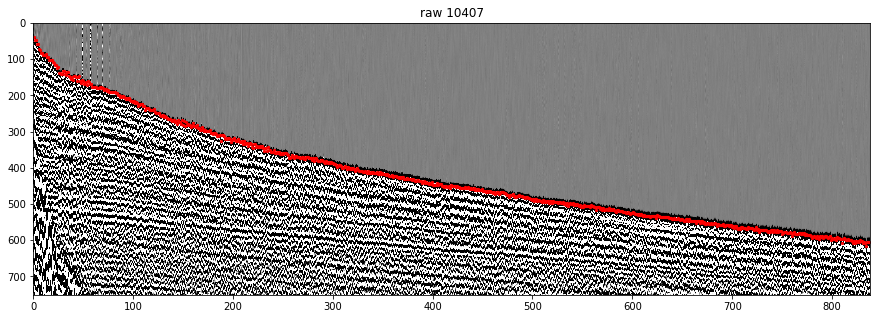

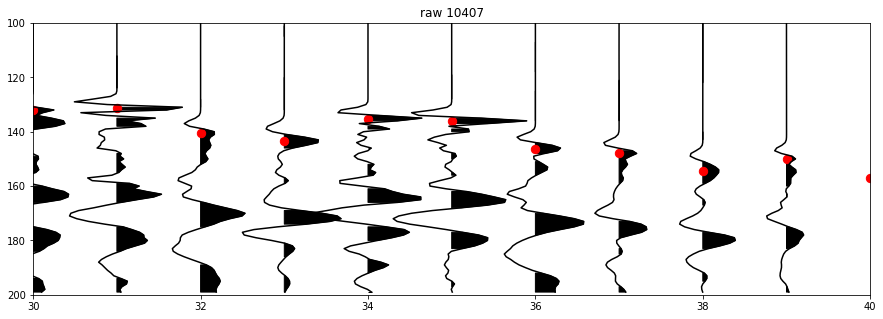

In [4]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, scatter_color='r')
      .seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                    figsize=(15,5), vmax=cv, vmin=-cv, s=70, scatter_color='r',
                    wiggle=True, xlim=(30,40), ylim=(100,200), std=0.1))

Selecting field records and traces for model training. We use 90% of the traces as training exampes. The rest is for test.

In [5]:
train_index = index.create_subset(index.indices[:900])
train_data = Dataset(TraceIndex(train_index), SeismicBatch)

In [6]:
test_index = index.create_subset(index.indices[900:])
test_data = Dataset(TraceIndex((test_index)), SeismicBatch)

## Model Architecture

We are using 1D Unet type of model with 5 blocks.

Model's configuration:      
* upsample: ConvTranspose1d - BatchNorm - Relu   
* downsample: MaxPool1d
* encoder block: Conv1d - BatchNorm - Relu - Conv1d - BatchNorm - Relu - downsample
* decoder block: upsample - Conv1d - BatchNorm - Relu - Conv1d - BatchNorm - Relu   
* head: Conv1d

Layes parameters:   

Conv1d(body):
* ```filters``` = ```[8, 16, 32, 64, 128]``` - depending on the depth, up to bottom
* ```kernel_size``` = 5
* ```padding``` = ```'same'```

Conv1d(head):
* ```filters``` = 2 
* ```kernel_size``` = 1
* ```padding``` = ```'same'```

ConvTransposed1d:
* ```filters``` = ```[64, 32, 16, 8]``` - depending on the depth, bottom to up
* ```kernel_size``` = 2
* ```strides``` = 2
* ```padding``` = ```'same'```

MaxPool1d:
* ```pool_size``` = 2
* ```pool_strides``` = 2
* ```padding``` = 1

Activation:
* ```activation``` = ``Relu``

In [7]:
inputs_config = {
    'raw': {'shape': (1, F(lambda batch: batch.raw.shape[2]))}, 
    'mask': {'shape': (1, F(lambda batch: batch.raw.shape[2])),
              'classes': 2}
    }

config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head/num_classes': 2, 
    'body/num_blocks': 5,
    'body/filters': [8, 16, 32, 64, 128], 
    'body/encoder': dict(layout='cna cna', kernel_size=5),
    'body/decoder': dict(layout='cna cna', kernel_size=5),
    'body/downsample' : dict(layout='p', pool_size=2, pool_strides=2, padding=1),
    'device': 'gpu:0',
}

## Hyperparameters estimation.

See the [research notebook](https://github.com/analysiscenter/SeismicPro/blob/supervised_picking/models/First_break_picking/1d_CNN/research.ipynb) for investigation of parameters influence on the model performance.

## Training

Training pipeline actions:   
* Load raw traces and labels.
* Normalize the traces to the zero mean and unit variance.
* Convert labeled picking to the mask for futher pixel-wise classification.
* Preprocess the batch of traces to make it compatible with torch models.

Training process:
* Optimizer: Adam, learning rate 0.001
* Batch size: 64, n_iters: 1000

Set the train pipeline.

In [8]:
train_pipeline = (train_data.p
                      .init_model('dynamic', UNet, 'my_model', config=config)
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standartize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss', mode='a'))
                      .run_later(64, n_iters=1000, drop_last=True, shuffle=True, bar=True))

Run the train pipeline.

In [10]:
train_pipeline.run()

100%|██████████| 1000/1000 [02:35<00:00,  6.64it/s]


Loss function plot. Cross entropy on the batch against iterations.   
Loss converged to near-zero plateu.

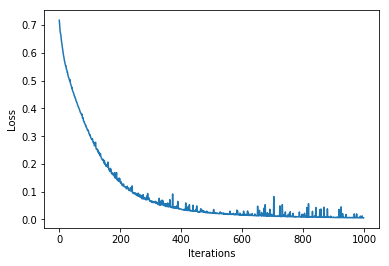

In [11]:
loss = train_pipeline.get_variable('loss')
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.plot(loss)

Save the model.

In [ ]:
train_pipeline.save_model_now('my_model', path='model_9hours.dill')

## Inference

Inference pipeline:

In [12]:
config_predict = {
    'build': False,
    'load/path':  '../model_9hours.dill',
    'device': 'gpu:0'
}

test_pipeline = (test_data.p
                      .init_model('dynamic', UNet, 'my_model', config=config_predict) 
                      .init_variable('true', init_on_each_run=list())
                      .init_variable('traces', init_on_each_run=list())
                      .init_variable('predictions', init_on_each_run=list())
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standartize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .update_variable('traces', B('raw'), mode='a')
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .update_variable('true', B('mask'), mode='a')                 
                      .add_components(components='predictions')
                      .predict_model('my_model', B('raw'), fetches='predictions',
                                       save_to=B('predictions', mode='a'))
                      .mask_to_pick(src='predictions', dst='predictions', labels=False)
                      .update_variable('predictions', B('predictions'), mode='a')
                      .dump(src='predictions', fmt='picks',path='model_predictions.csv', traces='raw', to_samples=True)
                      .run_later(1000, n_epochs=1, drop_last=False, shuffle=False, bar=True))

Run the inference pipeline on the test_dataset.   
Model results are dumped to the file **model_predictions.csv**.

In [13]:
test_pipeline.run()

 99%|█████████▉| 83/84 [00:19<00:00,  4.44it/s]


## Running time

System config:
* GPU: GTX GeForce 1080
* CPU(s): 40
* Model name: Intel Xeon E5-2630

Time performance:
* Single model training iteration with batch size=64: 0.18 sec.
* Inference iteration on the batch of 1000 traces: 0.25 sec.

## Model evaluation

We evaluate the model perfomance on two different datasets.

### Dataset 1

Arrange results:

In [14]:
pred = np.hstack(np.concatenate(test_pipeline.get_variable('predictions')))
true = np.argmax(np.vstack(test_pipeline.get_variable('true')), axis=1)
raw = np.vstack(np.concatenate(test_pipeline.get_variable('traces')))

Calculate metrics.

In [15]:
metrics = PickingMetrics(true, pred, gap=3)

Even though picking is a regression task, we can consider its classification interpretation as well.   
If ground truth and model predictions differs on 3 samples or more in absolute terms, then we consider such trace as not properly classified.   
The ***gap*** parameter stands for it.

#### Visual estimation.

Draw the seismogram with predictions(blue) and targets(red).

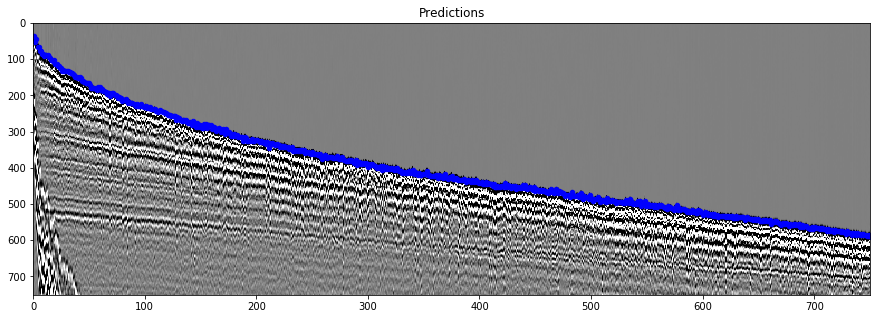

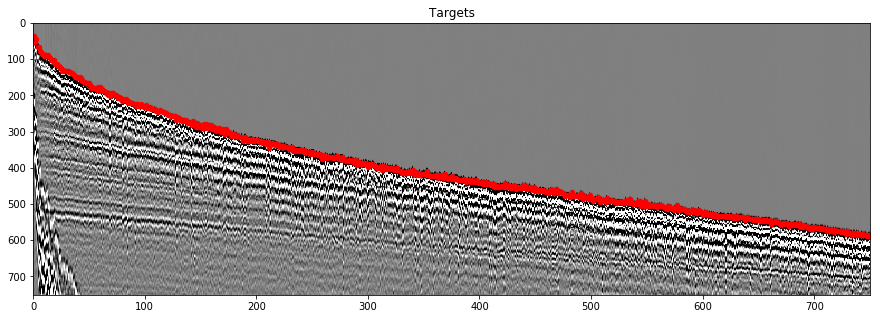

In [16]:
cv = 1
pts = (range(len(pred)), pred)
seismic_plot(raw, cmap='gray',vmax=cv, vmin=-cv, pts=pts, xlim=(0, 750),
             s=20, scatter_color='b', figsize=(15, 5), names=['Predictions'])

pts = (range(len(true)), true)
seismic_plot(raw, cmap='gray',vmax=cv, vmin=-cv, pts=pts, xlim=(0, 750),
             s=20, scatter_color='r', figsize=(15, 5), names=['Targets'])

#### Absolute error distribution.

However, take a look at the distribution of absolute error.   
In 82405 traces out of 83132 on the test data we predict picking sample to sample with targets.

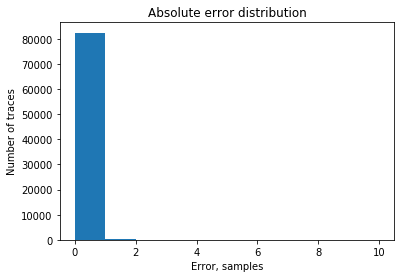

In [17]:
plt.title('Absolute error distribution')
plt.xlabel('Error, samples')
plt.ylabel('Number of traces')
_ = plt.hist(abs(true-pred), range=(0,10), bins=10)

#### MAE metrics.

Mean absolute error.

In [18]:
print('MAE on dataset 1 validation: {0:.3f}'.format(metrics.evaluate('mae')))

MAE on dataset 1 validation: 0.064


#### Accuracy metrics.

In [19]:
print('Accuracy on dataset 1 validation: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on dataset 1 validation: 99.77%


We conclude that the model trained on dataset 1  is able to find picking for traces from the same dataset.

### Dataset 2

Same steps for dataset 2.

Set the paths to SEG files and labeled picking.

In [20]:
path_raw = '/notebooks/egor/FB/WZ/WZ_Flatiron_1k.sgy'
markup_path='/notebooks/egor/FB/WZ/WZ_Flatiron_1k_picking.csv'

Load 100 seismofields from dataset 2 for model evaluation.

In [21]:
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
test_index = index.create_subset(index.indices[900:])
test_data = Dataset(TraceIndex((test_index)), SeismicBatch)

Run inference pipeline on the traces from dataset 2.

In [22]:
(test_pipeline << test_data).run(500, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 99%|█████████▉| 90/91 [00:11<00:00,  7.62it/s]


Arrange results:

In [23]:
true_2 = np.argmax(np.vstack(test_pipeline.get_variable('true')), axis=1)
pred_2 = np.hstack(np.concatenate(test_pipeline.get_variable('predictions')))
raw_2 = np.vstack(np.concatenate(test_pipeline.get_variable('traces')))

Calculate metrics for dataset 2.

In [24]:
metrics = PickingMetrics(true_2, pred_2, gap=3)

#### Visual estimation.

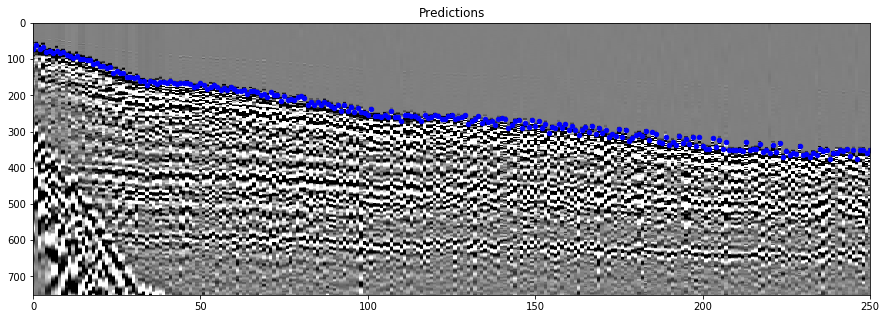

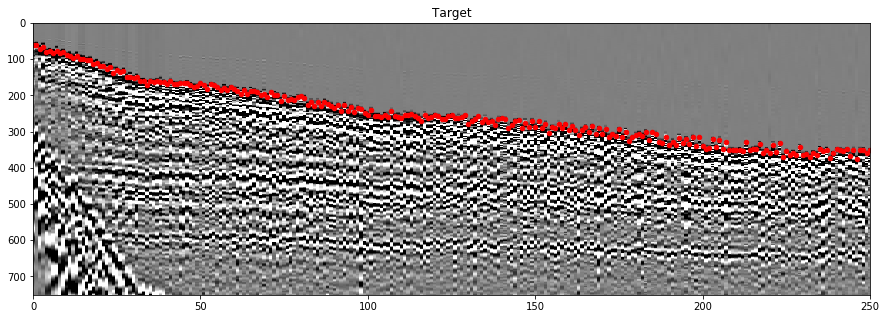

In [25]:
cv = 1
pts = (range(len(pred_2)), pred_2)
seismic_plot(raw_2, cmap='gray',vmax=cv, vmin=-cv, pts=pts, xlim=(0, 250),
             s=20, scatter_color='b', figsize=(15, 5), names=['Predictions'])

pts = (range(len(true_2)), true_2)
seismic_plot(raw_2, cmap='gray',vmax=cv, vmin=-cv, pts=pts, xlim=(0, 250),
             s=20, scatter_color='r', figsize=(15, 5), names=['Target'])

#### Absolute error distribution.

In 33056 traces out of 45018 we predict sample to sample.

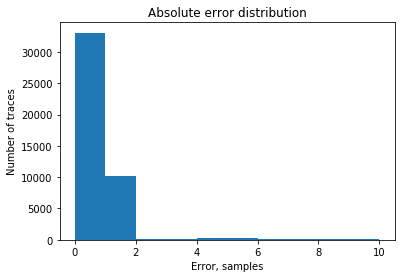

In [26]:
plt.title('Absolute error distribution')
plt.xlabel('Error, samples')
plt.ylabel('Number of traces')
arr = plt.hist(abs(true_2 - pred_2), range=(0,10), bins=10)

#### MAE metrics.

In [27]:
print('MAE on dataset 2 validation: {0:.3f}'.format(metrics.evaluate('mae')))

MAE on dataset 2 validation: 0.695


#### Accuracy metrics.

In [28]:
print('Accuracy on dataset 1 validation: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on dataset 1 validation: 96.24%


As it was expected, the perfomance on the traces from the dataset the model did not see during training is  worse.

## Criticism

#### 20 most poorly predicted traces

Take a look at 20 traces where the model mistakes the most. The traces on the plot are sorted from the right to the left. Traces on the right are the ones where the models mistakes the most.

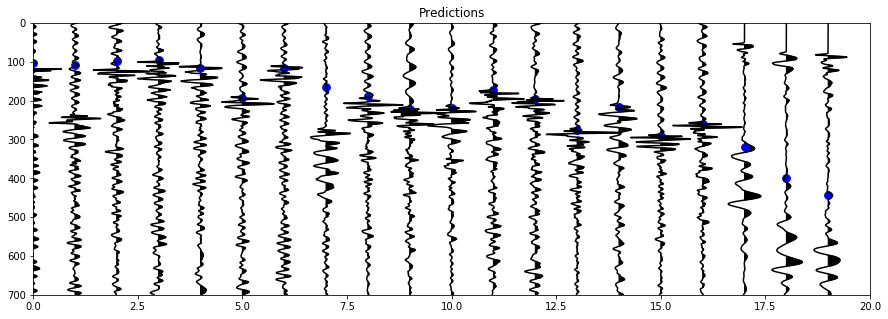

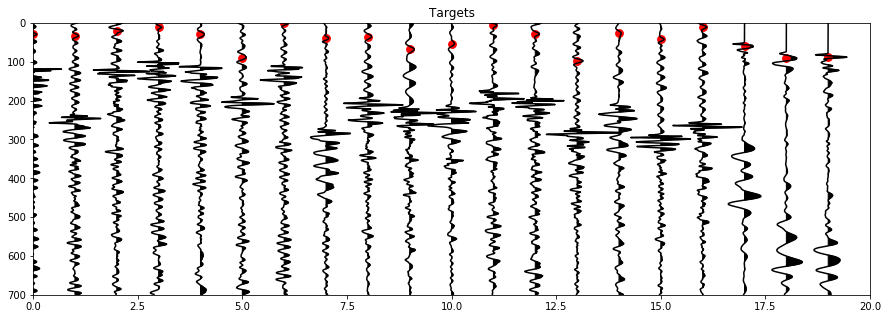

In [29]:
difference = abs(true-pred)
worst = difference.argsort()[-20:]

s = 60
std = 0.1
ylim = (0, 700)
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(pred[worst])), pred[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, scatter_color='b', std = std, ylim=ylim, names=['Predictions'])
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(true[worst])), true[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, scatter_color='r', std = std, ylim=ylim, names=['Targets'])

### One of the poorly predicted trace and its direct neighboors.

Take a closer look at one of the the poorly predicted traces and its neighboors.   
There is a trace with significant level of noise, which forces the unsupervised model to mistake and therefore providing model with uncorrect labeled data.   
However, there are still traces where the CNN model misses the onset of signal arrival.

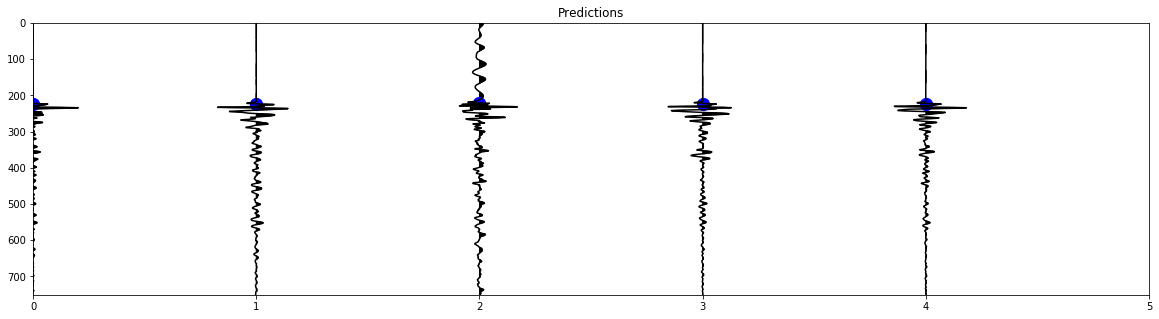

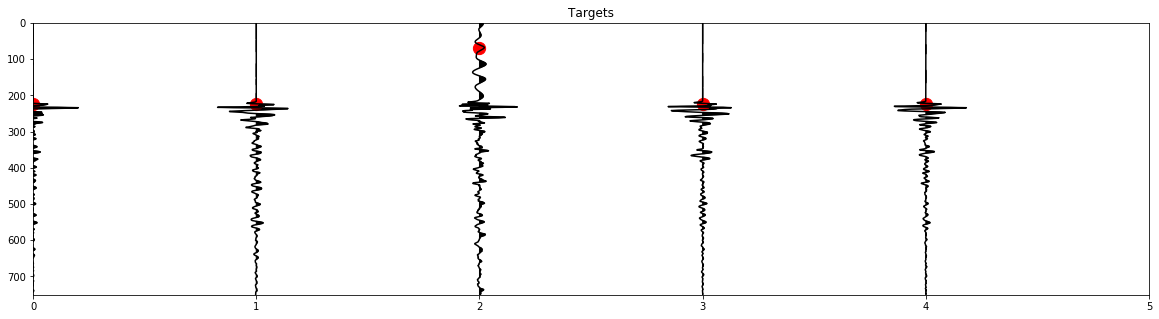

In [30]:
k = 9
nworst = [worst[k] - 2, worst[k] - 1, worst[k], worst[k] + 1, worst[k] + 2]
ylim = (min(np.concatenate((true[nworst], pred[nworst]))) - 10, max(np.concatenate((true[nworst], pred[nworst]))) + 100)
s = 150
std = 0.02
seismic_plot((raw[nworst]), cmap='gray', wiggle=True, pts=(range(len(pred[nworst])), pred[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, scatter_color='b', std = std, names=['Predictions'])
seismic_plot(raw[nworst], cmap='gray', wiggle=True, pts=(range(len(true[nworst])), true[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, scatter_color='r', std = std, names=['Targets'])

## Conclusion

The model finds first break picking, but it quite sencitive to the traces with the significant noise amplitudes before signal.   
The model generalises the pattern of first break picking and shows not bad results on the valudation on the traces from  different dataset rather than training ones.   
However, not always correct ground truth labels and noise in the signal is two main challenges in this task.